In [101]:
import pandas as pd
from collections import OrderedDict
import pytz
import helper
import pnf
import math

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Collect ETF data from API and create Pandas Panel
Grab Sector ETF data from Alpha Vantage API and then save each ETF's data into a separate date-indexed CSV file.

In [59]:
etf_panel = helper.get_sector_etf_panel()

In [60]:
etf_panel.minor_axis = ['Open', 'High', 'Low', 'Close', 'Volume']

# Generate Trading Strategy
Create the trading strategy for a particular year. To do this, we will determine which sector ETF is the strongest performer on a monthly basis. This analysis will be done at the end of the month to inform trading for the following month. We will invest 100% of our portfolio into the best strongest ETF each month based on relative strength. At the end of the month, if the analysis shows that the strongest ETF is different that the ETF we are currently invested in, we will divest all money in the current ETF and invest 100% of capital into the ETF that has overtaken old ETF as the strongest.

In [61]:
# Run through each month in date range and get highest RS ETF for each month
start_year = 2017
end_year = 2017
monthly_start_dates, monthly_end_dates = helper.create_monthly_date_ranges(start_year, end_year)
monthly_best_performers = OrderedDict()

for idx in range(len(monthly_start_dates)):
    start_date = monthly_start_dates[idx]
    end_date = monthly_end_dates[idx]
    
    # Construct panel for this month
    panel = etf_panel.copy()
    for symbol in list(etf_panel.items):
        panel[symbol] = panel[symbol][start_date : end_date]
    panel = panel.dropna(axis=1)
        
    # Create RS matrix for this month
    rs_matrix = pnf.run_rs_matrix(panel)
    
    # Select the sector with the highest total and append to best performers dict. The key for
    # this dict is the start date of the next month
    best_sector = rs_matrix['total'].idxmax()
    if idx != (len(monthly_start_dates) - 1):
        monthly_best_performers[monthly_start_dates[idx + 1]] = best_sector
    
    print('Running RS matrix for {0} - {1}'.format(start_date, end_date), end='\r', flush=True)
    
print(monthly_best_performers)

OrderedDict([('2017-02-01', 'XLU'), ('2017-03-01', 'XLU'), ('2017-04-01', 'XLB'), ('2017-05-01', 'XLB'), ('2017-06-01', 'XLU'), ('2017-07-01', 'XLF'), ('2017-08-01', 'XLE'), ('2017-09-01', 'XLV'), ('2017-10-01', 'XLF'), ('2017-11-01', 'XLK'), ('2017-12-01', 'XLI')])


# Run Strategy Through Zipline
Using the trading strategy structure generated in the previous step, run the strategy through zipline to see what ROI is for sector rotation strategy.

In [109]:
from zipline.api import order, record, symbol, set_benchmark, order_target
import zipline
from datetime import datetime

# Make list of algo dictionary to use
best_performers_dict = monthly_best_performers
best_performers_keys = []
for key in list(monthly_best_performers.keys()):
    best_performers_keys.append(key)    

def initialize(context):
    context.curr_month_idx = 0
    context.best_performers_keys = best_performers_keys
    context.best_performers_dict = best_performers_dict
    context.current_month = ''
    context.current_best_performer = ''
    context.previous_best_performer = ''
    context.next_month = best_performers_keys[context.curr_month_idx]
    set_benchmark(symbol('XLB'))

def handle_data(context, data):
    # Check today's date -- if it is >= start of next month, place order for new ETF
    if context.datetime >= pd.to_datetime(context.next_month).tz_localize(pytz.utc):
        # Get best performer for this month
        key = context.best_performers_keys[context.curr_month_idx]
        context.current_best_performer = context.best_performers_dict[key]
        # Set current/next month
        context.current_month = context.next_month
        if context.curr_month_idx < (len(context.best_performers_keys) - 1):
            context.next_month = context.best_performers_keys[context.curr_month_idx + 1]
            context.curr_month_idx += 1
            
        # Get best performer of the month
        context.current_best_performer = context.best_performers_dict[context.current_month]
    
        # Place Order only if best performer different than last month's best performer
        if context.current_best_performer != context.previous_best_performer:
            # Sell previous shares, if any
            if context.previous_best_performer != '':                
                order_target(symbol(context.previous_best_performer), 0)
            # Buy  as much of best performer as possible
            # Divide portfolio value by close price of best_performer to get number of shares
            best_performer_close = data.current(symbol(context.current_best_performer), 'price')
            num_shares_to_buy = math.floor(context.portfolio.portfolio_value / best_performer_close)
            order(symbol(context.current_best_performer), num_shares_to_buy)
            # Record benchmark value
            record(XLB=data.current(symbol('XLB'), 'price'))
            record(CURR=context.current_best_performer)
            # Set this best performer as the previous best performer for next month's itteration
            context.previous_best_performer = context.current_best_performer
    
# Change panel minor axis to use Zipline compatible labels
minor_axis = ['open', 'high', 'low', 'close', 'volume']
etf_panel.minor_axis = minor_axis
    
perf = zipline.run_algorithm(start=datetime(2017, 2, 2, 0, 0, 0, 0, pytz.utc),
                             end=datetime(2017, 12, 31, 0, 0, 0, 0, pytz.utc),
                             initialize=initialize,
                             capital_base = 10000,
                             handle_data = handle_data,
                             data = etf_panel)


In [111]:
#import matplotlib.pyplot as plt
perf.head(150)


,CURR,XLB,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-02-02 21:00:00+00:00,XLU,51.99,NaN,0.000000,NaN,-0.004404,NaN,NaN,0.000000,10000.000000,...,0.0,0.0,0,NaN,10000.000000,0.00,0.00,1,[],0.0
2017-02-03 21:00:00+00:00,XLU,51.99,0.005828,-0.000519,-0.093920,-0.002681,0.068871,-0.084618,-9980.791800,19.208200,...,0.0,0.0,0,-11.224972,10000.000000,0.00,0.00,2,[{'order_id': '5f5a85ab280d4398a63f565325479eb...,0.0
2017-02-06 21:00:00+00:00,XLU,51.99,0.016839,-0.002559,-0.214782,-0.005362,0.050250,0.000618,0.000000,19.208200,...,0.0,0.0,0,-11.141671,19.208200,9975.60,9975.60,3,[],0.0
2017-02-07 21:00:00+00:00,XLU,51.99,0.029636,-0.000111,-0.269972,-0.013213,0.063503,-0.315295,0.000000,19.208200,...,0.0,0.0,0,-0.399335,19.208200,9955.20,9955.20,4,[],0.0
2017-02-08 21:00:00+00:00,XLU,51.99,0.074287,0.009681,0.706996,-0.010915,0.068038,0.397252,0.000000,19.208200,...,0.0,0.0,0,32.654306,19.208200,9979.68,9979.68,5,[],0.0
2017-02-09 21:00:00+00:00,XLU,51.99,0.094752,0.001113,0.135113,-0.011298,0.061960,0.178164,0.000000,19.208200,...,0.0,0.0,0,0.890418,19.208200,10077.60,10077.60,6,[],0.0
2017-02-10 21:00:00+00:00,XLU,51.99,0.093960,0.007437,0.302184,-0.002298,0.086870,0.396184,0.000000,19.208200,...,0.0,0.0,0,5.159328,19.208200,9991.92,9991.92,7,[],0.0
2017-02-13 21:00:00+00:00,XLU,51.99,0.089548,0.012333,0.312210,0.005936,0.093709,0.408198,0.000000,19.208200,...,0.0,0.0,0,7.945746,19.208200,10055.16,10055.16,8,[],0.0
2017-02-14 21:00:00+00:00,XLU,51.99,0.095842,0.004989,0.071831,0.005745,0.087800,0.437107,0.000000,19.208200,...,0.0,0.0,0,2.386349,19.208200,10104.12,10104.12,9,[],0.0
2017-02-15 21:00:00+00:00,XLU,51.99,0.091611,0.002541,0.016195,0.004404,0.083375,0.452480,0.000000,19.208200,...,0.0,0.0,0,1.161203,19.208200,10030.68,10030.68,10,[],0.0


In [25]:
dir(monthly_best_performers._OrderedDict__map['2017-01-01'])

AttributeError: 'collections.OrderedDict' object has no attribute '_OrderedDict__map'

In [57]:

# Make copy of algo dictionary to use
best_performers = []
for key in list(monthly_best_performers.keys()):
    best_performers.append((key, monthly_best_performers[key]))
    
print(best_performers)

[('2017-04-01', 'XLB'), ('2017-05-01', 'XLB'), ('2017-06-01', 'XLU'), ('2017-07-01', 'XLF'), ('2017-08-01', 'XLE'), ('2017-09-01', 'XLV'), ('2017-10-01', 'XLF'), ('2017-11-01', 'XLK'), ('2017-12-01', 'XLI')]


In [66]:
# Make list of algo dictionary to use
best_performers_dict = monthly_best_performers
best_performers_keys = []
for key in list(monthly_best_performers.keys()):
    best_performers_keys.append(key)    

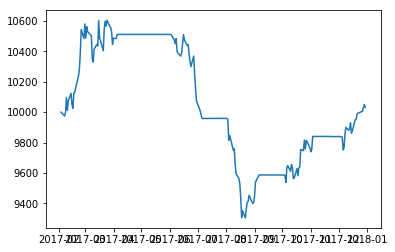

In [117]:
import matplotlib.pyplot as plt
plot = plt.plot(perf.portfolio_value)
plt.show()